# Visualization Gallery

This notebook shows common visualization issues encountered in xarray.

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline

Load example dataset:

In [2]:
ds = xr.tutorial.load_dataset("air_temperature")

## Multiple plots and map projections

Control the map projection parameters on multiple axes

This example illustrates how to plot multiple maps and control their extent
and aspect ratio.

For more details see [this discussion](https://github.com/pydata/xarray/issues/1397#issuecomment-299190567) on github.

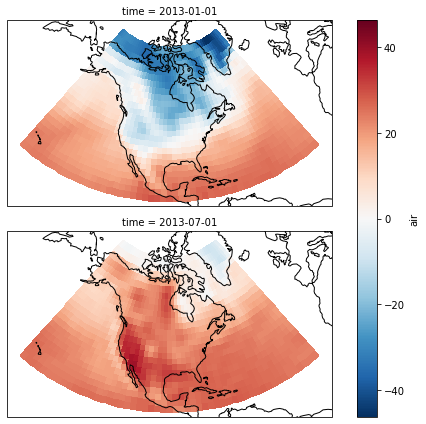

In [3]:
air = ds.air.isel(time=[0, 724]) - 273.15

# This is the map projection we want to plot *onto*
map_proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)

p = air.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    col="time",
    col_wrap=1,  # multiplot settings
    aspect=ds.dims["lon"] / ds.dims["lat"],  # for a sensible figsize
    subplot_kws={"projection": map_proj},
)  # the plot's projection

# We have to set the map's options on all axes
for ax in p.axes.flat:
    ax.coastlines()
    ax.set_extent([-160, -30, 5, 75])

## Centered colormaps

Xarray's automatic colormaps choice

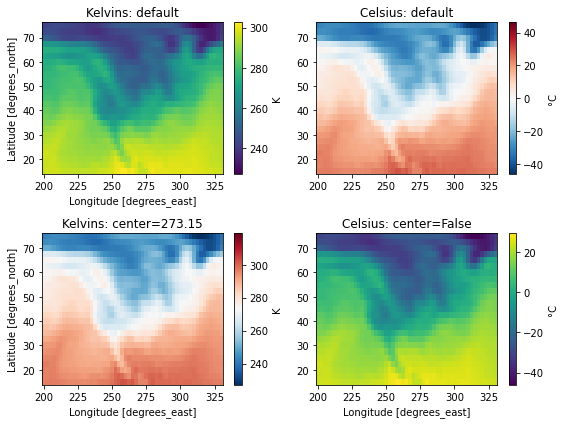

In [4]:
air = ds.air.isel(time=0)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))

# The first plot (in kelvins) chooses "viridis" and uses the data's min/max
air.plot(ax=ax1, cbar_kwargs={"label": "K"})
ax1.set_title("Kelvins: default")
ax2.set_xlabel("")

# The second plot (in celsius) now chooses "BuRd" and centers min/max around 0
airc = air - 273.15
airc.plot(ax=ax2, cbar_kwargs={"label": "°C"})
ax2.set_title("Celsius: default")
ax2.set_xlabel("")
ax2.set_ylabel("")

# The center doesn't have to be 0
air.plot(ax=ax3, center=273.15, cbar_kwargs={"label": "K"})
ax3.set_title("Kelvins: center=273.15")

# Or it can be ignored
airc.plot(ax=ax4, center=False, cbar_kwargs={"label": "°C"})
ax4.set_title("Celsius: center=False")
ax4.set_ylabel("")

# Make it nice
plt.tight_layout()

## Control the plot's colorbar

Use ``cbar_kwargs`` keyword to specify the number of ticks.
The ``spacing`` kwarg can be used to draw proportional ticks.

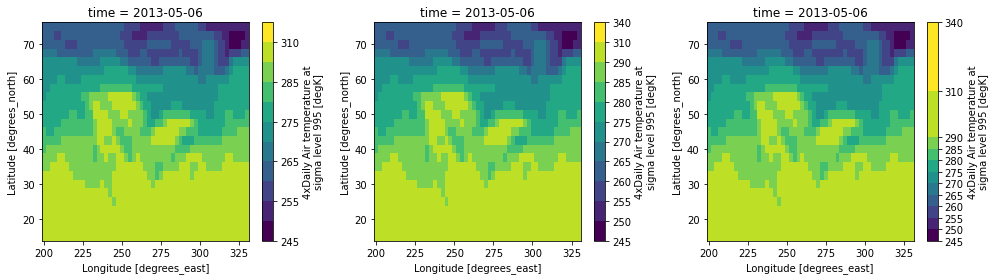

In [5]:
air2d = ds.air.isel(time=500)

# Prepare the figure
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

# Irregular levels to illustrate the use of a proportional colorbar
levels = [245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 310, 340]

# Plot data
air2d.plot(ax=ax1, levels=levels)
air2d.plot(ax=ax2, levels=levels, cbar_kwargs={"ticks": levels})
air2d.plot(
    ax=ax3, levels=levels, cbar_kwargs={"ticks": levels, "spacing": "proportional"}
)

# Show plots
plt.tight_layout()

## Multiple lines from a 2d DataArray

Use ``xarray.plot.line`` on a 2d DataArray to plot selections as
multiple lines.

See ``plotting.multiplelines`` for more details.

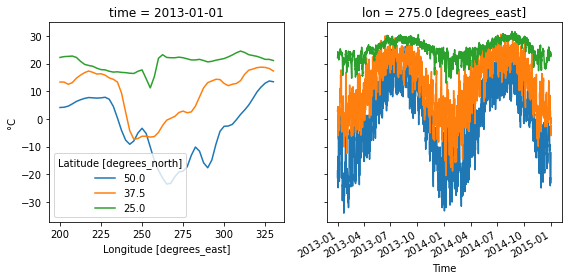

In [6]:
air = ds.air - 273.15  # to celsius

# Prepare the figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# Selected latitude indices
isel_lats = [10, 15, 20]

# Temperature vs longitude plot - illustrates the "hue" kwarg
air.isel(time=0, lat=isel_lats).plot.line(ax=ax1, hue="lat")
ax1.set_ylabel("°C")

# Temperature vs time plot - illustrates the "x" and "add_legend" kwargs
air.isel(lon=30, lat=isel_lats).plot.line(ax=ax2, x="time", add_legend=False)
ax2.set_ylabel("")

# Show
plt.tight_layout()

## `imshow()` and rasterio map projections


Using rasterio's projection information for more accurate plots.

This example extends `recipes.rasterio` and plots the image in the
original map projection instead of relying on pcolormesh and a map
transformation.

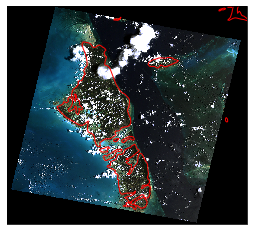

In [7]:
da = xr.tutorial.open_rasterio("RGB.byte")

# The data is in UTM projection. We have to set it manually until
# https://github.com/SciTools/cartopy/issues/813 is implemented
crs = ccrs.UTM("18")

# Plot on a map
ax = plt.subplot(projection=crs)
da.plot.imshow(ax=ax, rgb="band", transform=crs)
ax.coastlines("10m", color="r")

## Parsing rasterio geocoordinates

Converting a projection's cartesian coordinates into 2D longitudes and
latitudes.

These new coordinates might be handy for plotting and indexing, but it should
be kept in mind that a grid which is regular in projection coordinates will
likely be irregular in lon/lat. It is often recommended to work in the data's
original map projection (see `recipes.rasterio_rgb`).

/usr/lib/python3/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


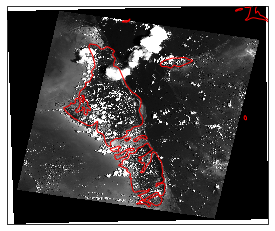

In [8]:
from pyproj import Transformer
import numpy as np

da = xr.tutorial.open_rasterio("RGB.byte")

x, y = np.meshgrid(da["x"], da["y"])
transformer = Transformer.from_crs(da.crs, "EPSG:4326", always_xy=True)
lon, lat = transformer.transform(x, y)
da.coords["lon"] = (("y", "x"), lon)
da.coords["lat"] = (("y", "x"), lat)

# Compute a greyscale out of the rgb image
greyscale = da.mean(dim="band")

# Plot on a map
ax = plt.subplot(projection=ccrs.PlateCarree())
greyscale.plot(
    ax=ax,
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    cmap="Greys_r",
    shading="auto",
    add_colorbar=False,
)
ax.coastlines("10m", color="r")